**The AWS bucket is currently off-line, but rumor is it will come back. In the meantime, the data are also on Google Cloud**

In this notebook, we will download Copernicus ERA5 Data from a public Google Cloud bucket. Copernicus ERA5 is one of the most well-known reanalysis datasets on modern climate, providing a numerical assessment of the modern climate. The data are provided as an analysis ready (re-gridded) data set. [repo on the data](https://github.com/google-research/arco-era5#roadmap). The [data](https://cloud.google.com/storage/docs/public-datasets/era5).

## Variables

There are many variables available; see full list below. For the Indian Ocean Zarr dataset, we collect air temperature at 2m (2m_temperature), sea surface temperature (sea_surface_temperature), total precipitation (total_precipitation), direct solar radiation (total_sky_direct_solar_radiation_at_surface), total thermal radiation (surface_net_solar_radiation) and u and v wind components (10m_u_component_of_wind and 10m_v_component_of_wind). The latter two are used to compute speed and direction later. In addition, we will process the winds into 3 time periods of the day: 0-8 UTC, 9-16 UTC, and 17-24 UTC. This is the capture the dirunal nature of the winds.

In [122]:
iovars = {'2m_temperature', 'sea_surface_temperature', 'total_precipitation', 'total_sky_direct_solar_radiation_at_surface', 'surface_net_solar_radiation', '10m_u_component_of_wind', '10m_v_component_of_wind'}

## Install necessary libraries

In [2]:
import datetime
import matplotlib.pyplot as plt
import os
import xarray as xr
import numpy as np
import pandas as pd
import sys
# you don't need to import gcsfs but need to have it installed

## Examine the dataset

This will be fast because we are only loading metadata. It is petabytes of data so we will not load the whole data set into memory.

In [3]:
ds = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None,
    storage_options=dict(token='anon'),
)

This is hourly data.

In [4]:
ds

<xarray.Dataset> Size: 3PB
Dimensions:                                                          (
                                                                      time: 1089864,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
  * level                                                            (level) int64 296B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) datetime64[ns] 9MB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 5TB ...
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 5TB ...
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB ...
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 5TB ...
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB ...
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 5TB ...
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 5TB ...
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 5TB ...
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 5TB ...
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 5TB ...
    wave_spectral_skewness                                           (time, latitude, longitude) float32 5TB ...
    zero_degree_level                                                (time, latitude, longitude) float32 5TB ...

Show a demo file.

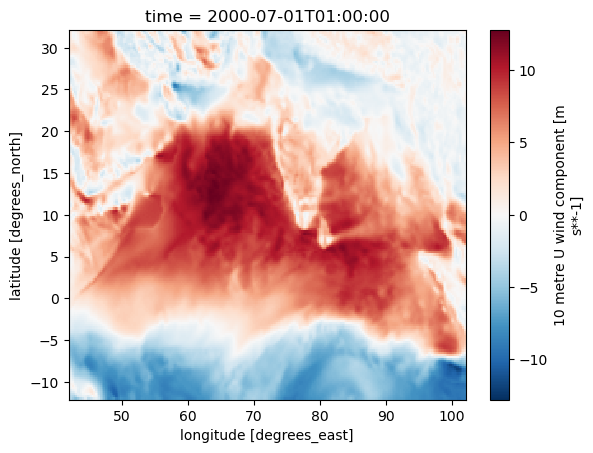

In [7]:
tmp = ds['10m_u_component_of_wind'].sel(latitude=slice(32, -12), longitude=slice(42, 102), time="2000-07-01")
tmp.isel(time=1).plot()

## Create a loop to process netCDF files

These are intermediary monthly files for our daily variables. The zarr file is too big to save all at once.

In [10]:
def download_era5_gc(vars, date_start, date_end, lat1=32, lat2=-12, lon1=42, lon2=102, path='/home/jovyan/shared/data/era5-gc'):
    """
    vars: era5 variables to write
    date_start: formatted as YYYY-MM-DD or numpy.datetime64(
    date_end: formatted as YYYY-MM-DD (right-exclusive)
    """

    fullds = xr.open_zarr(
        'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
        chunks=None,
        storage_options=dict(token='anon'),
    )
    # Slice to lat lon box and time box
    ioera5 = fullds[vars].sel(latitude=slice(lat1, lat2), longitude=slice(lon1, lon2), time=slice(date_start, date_end))
    
    months = pd.date_range(date_start, date_end, freq="ME")
    for month in months:
        print(f'{month.year}-{month.month}', end =", ")
        ds = ioera5.sel(time=month.strftime("%Y-%m"))

        # adding calculated variables (direction and speed)
        ds = ds.assign(wind_speed = np.sqrt(ds['10m_u_component_of_wind']**2 + ds['10m_v_component_of_wind']**2))
        ds = ds.assign(wind_dir = np.rad2deg(np.arctan2(ds['10m_v_component_of_wind'], ds['10m_u_component_of_wind'])))
        # coarsen to daily via mean over the 24 hours; this only works because there are not missing hours
        ds = ds.coarsen(time=24).mean(keep_attrs=True).compute()
        # set to stop warning about serialization due to format of the time element
        ds.time.encoding['units'] = 'minutes since 1900-01-01'

        vars.update({'wind_speed', 'wind_dir'})
        for var in vars:
            # export
            path_var_folder = f'{path}/{var}'
            if not os.path.exists(path_var_folder):
                os.makedirs(path_var_folder)

            sliced_data_file_ptrn = os.path.join(path_var_folder, '{year}{month}.nc')
            export_file = sliced_data_file_ptrn.format(year = month.year, month = "{:02d}".format(month.month))
            ds[var].to_netcdf(export_file)

Run the function to download the data.

In [136]:
iovars = {'2m_temperature', 'sea_surface_temperature', 'total_precipitation', 'total_sky_direct_solar_radiation_at_surface', 'surface_net_solar_radiation', '10m_u_component_of_wind', '10m_v_component_of_wind'}
download_era5_gc(iovars, "1979-01-01", "2024-04-30")

2000-1, 2000-2, 2000-3, 2000-4, 2000-5, 2000-6, 2000-7, 2000-8, 2000-9, 2000-10, 2000-11, 2000-12, 2001-1, 2001-2, 2001-3, 2001-4, 2001-5, 2001-6, 2001-7, 2001-8, 2001-9, 2001-10, 2001-11, 2001-12, 2002-1, 2002-2, 2002-3, 2002-4, 2002-5, 2002-6, 2002-7, 2002-8, 2002-9, 2002-10, 2002-11, 2002-12, 2003-1, 2003-2, 2003-3, 2003-4, 2003-5, 2003-6, 2003-7, 2003-8, 2003-9, 2003-10, 2003-11, 2003-12, 2004-1, 2004-2, 2004-3, 2004-4, 2004-5, 2004-6, 2004-7, 2004-8, 2004-9, 2004-10, 2004-11, 2004-12, 2005-1, 2005-2, 2005-3, 2005-4, 2005-5, 2005-6, 2005-7, 2005-8, 2005-9, 2005-10, 2005-11, 2005-12, 2006-1, 2006-2, 2006-3, 2006-4, 2006-5, 2006-6, 2006-7, 2006-8, 2006-9, 2006-10, 2006-11, 2006-12, 2007-1, 2007-2, 2007-3, 2007-4, 2007-5, 2007-6, 2007-7, 2007-8, 2007-9, 2007-10, 2007-11, 2007-12, 2008-1, 2008-2, 2008-3, 2008-4, 2008-5, 2008-6, 2008-7, 2008-8, 2008-9, 2008-10, 2008-11, 2008-12, 2009-1, 2009-2, 2009-3, 2009-4, 2009-5, 2009-6, 2009-7, 2009-8, 2009-9, 2009-10, 2009-11, 2009-12, 2010-1, 20

In [11]:
iovars = {'2m_temperature', 'sea_surface_temperature', 'total_precipitation', 'total_sky_direct_solar_radiation_at_surface', 'surface_net_solar_radiation', '10m_u_component_of_wind', '10m_v_component_of_wind'}
download_era5_gc(iovars, "1979-01-01", "1999-12-31")

1979-1, 1979-2, 1979-3, 1979-4, 1979-5, 1979-6, 1979-7, 1979-8, 1979-9, 1979-10, 1979-11, 1979-12, 1980-1, 1980-2, 1980-3, 1980-4, 1980-5, 1980-6, 1980-7, 1980-8, 1980-9, 1980-10, 1980-11, 1980-12, 1981-1, 1981-2, 1981-3, 1981-4, 1981-5, 1981-6, 1981-7, 1981-8, 1981-9, 1981-10, 1981-11, 1981-12, 1982-1, 1982-2, 1982-3, 1982-4, 1982-5, 1982-6, 1982-7, 1982-8, 1982-9, 1982-10, 1982-11, 1982-12, 1983-1, 1983-2, 1983-3, 1983-4, 1983-5, 1983-6, 1983-7, 1983-8, 1983-9, 1983-10, 1983-11, 1983-12, 1984-1, 1984-2, 1984-3, 1984-4, 1984-5, 1984-6, 1984-7, 1984-8, 1984-9, 1984-10, 1984-11, 1984-12, 1985-1, 1985-2, 1985-3, 1985-4, 1985-5, 1985-6, 1985-7, 1985-8, 1985-9, 1985-10, 1985-11, 1985-12, 1986-1, 1986-2, 1986-3, 1986-4, 1986-5, 1986-6, 1986-7, 1986-8, 1986-9, 1986-10, 1986-11, 1986-12, 1987-1, 1987-2, 1987-3, 1987-4, 1987-5, 1987-6, 1987-7, 1987-8, 1987-9, 1987-10, 1987-11, 1987-12, 1988-1, 1988-2, 1988-3, 1988-4, 1988-5, 1988-6, 1988-7, 1988-8, 1988-9, 1988-10, 1988-11, 1988-12, 1989-1, 19

In [13]:
iovars = {'10m_u_component_of_wind', '10m_v_component_of_wind'}
download_era5_gc(iovars, "2000-01-01", "2024-04-30")

2000-1, 2000-2, 2000-3, 2000-4, 2000-5, 2000-6, 2000-7, 2000-8, 2000-9, 2000-10, 2000-11, 2000-12, 2001-1, 2001-2, 2001-3, 2001-4, 2001-5, 2001-6, 2001-7, 2001-8, 2001-9, 2001-10, 2001-11, 2001-12, 2002-1, 2002-2, 2002-3, 2002-4, 2002-5, 2002-6, 2002-7, 2002-8, 2002-9, 2002-10, 2002-11, 2002-12, 2003-1, 2003-2, 2003-3, 2003-4, 2003-5, 2003-6, 2003-7, 2003-8, 2003-9, 2003-10, 2003-11, 2003-12, 2004-1, 2004-2, 2004-3, 2004-4, 2004-5, 2004-6, 2004-7, 2004-8, 2004-9, 2004-10, 2004-11, 2004-12, 2005-1, 2005-2, 2005-3, 2005-4, 2005-5, 2005-6, 2005-7, 2005-8, 2005-9, 2005-10, 2005-11, 2005-12, 2006-1, 2006-2, 2006-3, 2006-4, 2006-5, 2006-6, 2006-7, 2006-8, 2006-9, 2006-10, 2006-11, 2006-12, 2007-1, 2007-2, 2007-3, 2007-4, 2007-5, 2007-6, 2007-7, 2007-8, 2007-9, 2007-10, 2007-11, 2007-12, 2008-1, 2008-2, 2008-3, 2008-4, 2008-5, 2008-6, 2008-7, 2008-8, 2008-9, 2008-10, 2008-11, 2008-12, 2009-1, 2009-2, 2009-3, 2009-4, 2009-5, 2009-6, 2009-7, 2009-8, 2009-9, 2009-10, 2009-11, 2009-12, 2010-1, 20

## Adding day versus night wind

There is a strong day versus night spatial pattern of wind. We can look at the total solar radiation to see when the sun is strongest. Note that time is UTC and India is +5:30 so the peak is around 1:30-2pm in India. The peak and shape does not shift much as we are close to the equator.

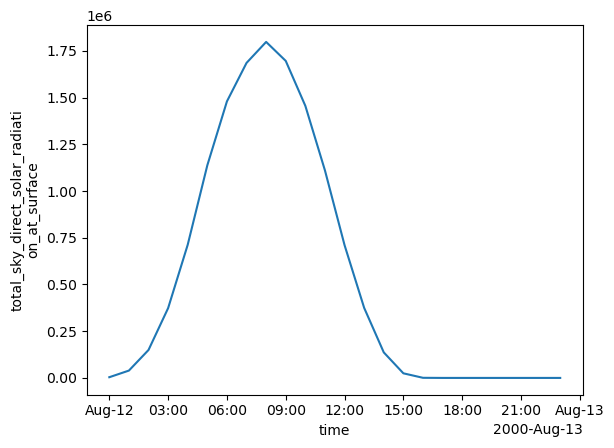

In [1]:
import xarray as xr
ds = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None,
    storage_options=dict(token='anon'),
)
# Slice to lat lon box and time box
ds1 = ds.sel(latitude=slice(32, -12), longitude=slice(42, 102), time="2000-08-12")
ds1['total_sky_direct_solar_radiation_at_surface'].mean(dim=["longitude", "latitude"]).plot()

If we look at the eastward wind, we see the day versus night difference and in particular the coastal winds off the southwest coast of India. 
Though shown for 2020, these winter and spring diurnal wind patterns are consistent across years.
During the summer monsoon, the winds are very strong and we do not see the diurnal pattern.

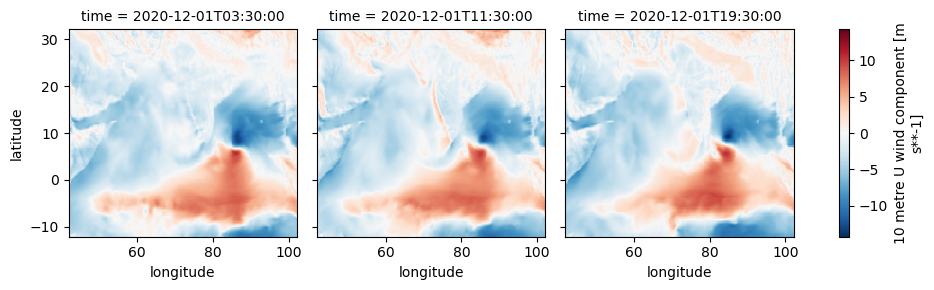

In [2]:
ds1 = ds['10m_u_component_of_wind'].sel(latitude=slice(32, -12), longitude=slice(42, 102), time="2020-12-01").coarsen(time=8).mean()
ds1.plot(x="longitude", y="latitude", col="time", col_wrap=3)

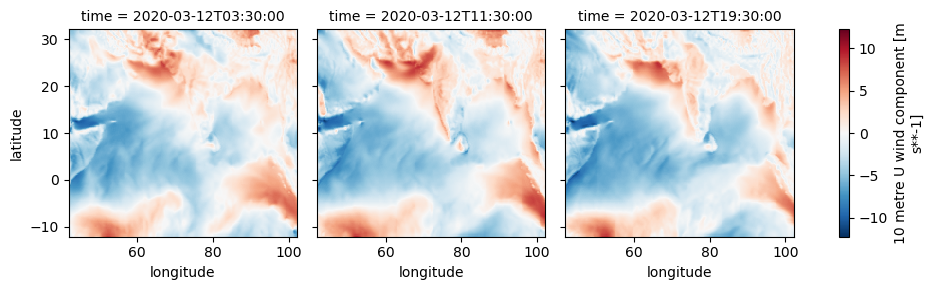

In [3]:
ds1 = ds['10m_u_component_of_wind'].sel(latitude=slice(32, -12), longitude=slice(42, 102), time="2020-03-12").coarsen(time=8).mean()
ds1.plot(x="longitude", y="latitude", col="time", col_wrap=3)

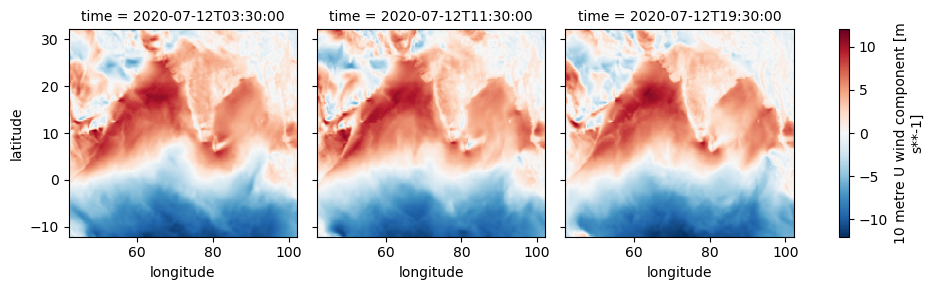

In [4]:
ds1 = ds['10m_u_component_of_wind'].sel(latitude=slice(32, -12), longitude=slice(42, 102), time="2020-07-12").coarsen(time=8).mean()
ds1.plot(x="longitude", y="latitude", col="time", col_wrap=3)

In [5]:
## Function to get winds at each 8hr block
def download_era5_gc_winds(date_start, date_end, lat1=32, lat2=-12, lon1=42, lon2=102, path='/home/jovyan/shared/data/era5-gc'):
    """
    vars: era5 variables to write
    date_start: formatted as YYYY-MM-DD or numpy.datetime64(
    date_end: formatted as YYYY-MM-DD (right-exclusive)
    """

    fullds = xr.open_zarr(
        'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
        chunks=None,
        storage_options=dict(token='anon'),
    )
    # Slice to lat lon box and time box
    vars = {'10m_u_component_of_wind', '10m_v_component_of_wind'}
    ioera5 = fullds[vars].sel(latitude=slice(lat1, lat2), longitude=slice(lon1, lon2), time=slice(date_start, date_end))
    
    months = pd.date_range(date_start, date_end, freq="ME")
    for month in months:
        print(f'{month.year}-{month.month}', end =", ")
        ds = ioera5.sel(time=month.strftime("%Y-%m"))

        # adding calculated variables (direction and speed)
        ds = ds.assign(wind_speed = np.sqrt(ds['10m_u_component_of_wind']**2 + ds['10m_v_component_of_wind']**2))
        ds = ds.assign(wind_dir = np.rad2deg(np.arctan2(ds['10m_v_component_of_wind'], ds['10m_u_component_of_wind'])))
        # coarsen to daily via mean over the 24 hours; this only works because there are not missing hours
        ds = ds.coarsen(time=8).mean(keep_attrs=True).compute()
        # set to stop warning about serialization due to format of the time element
        ds.time.encoding['units'] = 'minutes since 1900-01-01'

        for var in {'10m_u_component_of_wind', '10m_v_component_of_wind', 'wind_speed', 'wind_dir'}:
            for hr in {3, 11, 19}:
                path_var_folder = f'{path}/{var}_hr{hr}UTC'
                if not os.path.exists(path_var_folder):
                    os.makedirs(path_var_folder)
                sliced_data_file_ptrn = os.path.join(path_var_folder, '{year}{month}.nc')
                export_file = sliced_data_file_ptrn.format(year = month.year, month = "{:02d}".format(month.month))
                ds[var].isel(time=(ds.time.dt.hour == hr)).to_netcdf(export_file)


In [ ]:
# Get the data
download_era5_gc_winds(ioera5.time.min().to_pandas(), ioera5.time.max().to_pandas())

2000-1, 2000-2, 2000-3, 2000-4, 2000-5, 2000-6, 2000-7, 2000-8, 2000-9, 2000-10, 2000-11, 2000-12, 2001-1, 2001-2, 2001-3, 2001-4, 2001-5, 2001-6, 2001-7, 2001-8, 2001-9, 2001-10, 2001-11, 2001-12, 2002-1, 2002-2, 2002-3, 2002-4, 2002-5, 2002-6, 2002-7, 2002-8, 2002-9, 2002-10, 2002-11, 2002-12, 2003-1, 2003-2, 2003-3, 2003-4, 2003-5, 2003-6, 2003-7, 2003-8, 2003-9, 2003-10, 2003-11, 2003-12, 2004-1, 2004-2, 2004-3, 2004-4, 2004-5, 2004-6, 2004-7, 2004-8, 2004-9, 2004-10, 2004-11, 2004-12, 2005-1, 2005-2, 2005-3, 2005-4, 2005-5, 2005-6, 2005-7, 2005-8, 2005-9, 2005-10, 2005-11, 2005-12, 2006-1, 2006-2, 2006-3, 2006-4, 2006-5, 2006-6, 2006-7, 2006-8, 2006-9, 2006-10, 2006-11, 2006-12, 2007-1, 2007-2, 2007-3, 2007-4, 2007-5, 2007-6, 2007-7, 2007-8, 2007-9, 2007-10, 2007-11, 2007-12, 2008-1, 2008-2, 2008-3, 2008-4, 2008-5, 2008-6, 2008-7, 2008-8, 2008-9, 2008-10, 2008-11, 2008-12, 2009-1, 2009-2, 2009-3, 2009-4, 2009-5, 2009-6, 2009-7, 2009-8, 2009-9, 2009-10, 2009-11, 2009-12, 2010-1, 20

In [ ]:
# Get the data
download_era5_gc_winds("1979-01-01", "1999-12-31")

## 

## Variables


| name                                             | short name | units     | docs                                                 | 
|--------------------------------------------------|------------|-----------|------------------------------------------------------|
| 100m_u_component_of_wind | u100 | m s**-1 | https://codes.ecmwf.int/grib/param-db/228246 |
| 100m_v_component_of_wind | v100 | m s**-1 | https://codes.ecmwf.int/grib/param-db/228247 |
| 10m_u_component_of_neutral_wind | u10n | m s**-1 | https://codes.ecmwf.int/grib/param-db/228131 |
| 10m_u_component_of_wind | u10 | m s**-1 | https://codes.ecmwf.int/grib/param-db/165 |
| 10m_v_component_of_neutral_wind | v10n | m s**-1 | https://codes.ecmwf.int/grib/param-db/228132 |
| 10m_v_component_of_wind | v10 | m s**-1 | https://codes.ecmwf.int/grib/param-db/166 |
| 10m_wind_gust_since_previous_post_processing | fg10 | m s**-1 | https://codes.ecmwf.int/grib/param-db/175049 |
| 2m_dewpoint_temperature | d2m | K | https://codes.ecmwf.int/grib/param-db/500018 |
| 2m_temperature | t2m | K | https://codes.ecmwf.int/grib/param-db/500013 |
| air_density_over_the_oceans | p140209 | kg m**-3 | https://codes.ecmwf.int/grib/param-db/140209 |
| angle_of_sub_gridscale_orography | anor | radians | https://codes.ecmwf.int/grib/param-db/162 |
| anisotropy_of_sub_gridscale_orography | isor | ~ | https://codes.ecmwf.int/grib/param-db/161 |
| benjamin_feir_index | bfi | dimensionless | https://codes.ecmwf.int/grib/param-db/140253 |
| boundary_layer_dissipation | bld | J m**-2 | https://codes.ecmwf.int/grib/param-db/145 |
| boundary_layer_height | blh | m | https://codes.ecmwf.int/grib/param-db/159 |
| charnock | chnk | ~ | https://codes.ecmwf.int/grib/param-db/148 |
| clear_sky_direct_solar_radiation_at_surface | cdir | J m**-2 | https://codes.ecmwf.int/grib/param-db/228022 |
| cloud_base_height | cbh | m | https://codes.ecmwf.int/grib/param-db/228023 |
| coefficient_of_drag_with_waves | cdww | dimensionless | https://codes.ecmwf.int/grib/param-db/140233 |
| convective_available_potential_energy | cape | J kg**-1 | https://codes.ecmwf.int/grib/param-db/59 |
| convective_inhibition | cin | J kg**-1 | https://codes.ecmwf.int/grib/param-db/228001 |
| convective_precipitation | cp | m | https://codes.ecmwf.int/grib/param-db/228143 |
| convective_rain_rate | crr | kg m**-2 s**-1 | https://codes.ecmwf.int/grib/param-db/228218 |
| convective_snowfall | csf | m of water equivalent | https://codes.ecmwf.int/grib/param-db/239 |
| convective_snowfall_rate_water_equivalent | csfr | kg m**-2 s**-1 | https://codes.ecmwf.int/grib/param-db/228220 |
| downward_uv_radiation_at_the_surface | uvb | J m**-2 | https://codes.ecmwf.int/grib/param-db/57 |
| duct_base_height | dctb | m | https://codes.ecmwf.int/grib/param-db/228017 |
| eastward_gravity_wave_surface_stress | lgws | N m**-2 s | https://codes.ecmwf.int/grib/param-db/195 |
| eastward_turbulent_surface_stress | ewss | N m**-2 s | https://codes.ecmwf.int/grib/param-db/180 |
| evaporation | e | m of water equivalent | https://codes.ecmwf.int/grib/param-db/182 |
| forecast_albedo | fal | (0 - 1) | https://codes.ecmwf.int/grib/param-db/243 |
| forecast_logarithm_of_surface_roughness_for_heat | flsr | ~ | https://codes.ecmwf.int/grib/param-db/245 |
| forecast_surface_roughness | fsr | m | https://codes.ecmwf.int/grib/param-db/244 |
| fraction_of_cloud_cover | cc | (0 - 1) | https://codes.ecmwf.int/grib/param-db/248 |
| free_convective_velocity_over_the_oceans | p140208 | m s**-1 |  |
| friction_velocity | zust | m s**-1 | https://codes.ecmwf.int/grib/param-db/228003 |
| geopotential_at_surface | z | m**2 s**-2 | https://codes.ecmwf.int/grib/param-db/129 |
| gravity_wave_dissipation | gwd | J m**-2 | https://codes.ecmwf.int/grib/param-db/197 |
| high_cloud_cover | hcc | (0 - 1) | https://codes.ecmwf.int/grib/param-db/3075 |
| high_vegetation_cover | cvh | (0 - 1) | https://codes.ecmwf.int/grib/param-db/28 |
| ice_temperature_layer_1 | istl1 | K | https://codes.ecmwf.int/grib/param-db/35 |
| ice_temperature_layer_2 | istl2 | K | https://codes.ecmwf.int/grib/param-db/36 |
| ice_temperature_layer_3 | istl3 | K | https://codes.ecmwf.int/grib/param-db/37 |
| ice_temperature_layer_4 | istl4 | K | https://codes.ecmwf.int/grib/param-db/38 |
| instantaneous_10m_wind_gust | i10fg | m s**-1 | https://codes.ecmwf.int/grib/param-db/228029 |
| instantaneous_eastward_turbulent_surface_stress | iews | N m**-2 | https://codes.ecmwf.int/grib/param-db/229 |
| instantaneous_large_scale_surface_precipitation_fraction | ilspf | (0 - 1) | https://codes.ecmwf.int/grib/param-db/228217 |
| instantaneous_moisture_flux | ie | kg m**-2 s**-1 | https://codes.ecmwf.int/grib/param-db/232 |
| instantaneous_northward_turbulent_surface_stress | inss | N m**-2 | https://codes.ecmwf.int/grib/param-db/230 |
| instantaneous_surface_sensible_heat_flux | ishf | W m**-2 | https://codes.ecmwf.int/grib/param-db/231 |
| k_index | kx | K | https://codes.ecmwf.int/grib/param-db/260121 |
| lake_bottom_temperature | lblt | K | https://codes.ecmwf.int/grib/param-db/228010 |
| lake_cover | cl | (0 - 1) | https://codes.ecmwf.int/grib/param-db/26 |
| lake_depth | dl | m | https://codes.ecmwf.int/grib/param-db/228007 |
| lake_ice_depth | licd | m | https://codes.ecmwf.int/grib/param-db/228014 |
| lake_ice_temperature | lict | K | https://codes.ecmwf.int/grib/param-db/228013 |
| lake_mix_layer_depth | lmld | m | https://codes.ecmwf.int/grib/param-db/228009 |
| lake_mix_layer_temperature | lmlt | K | https://codes.ecmwf.int/grib/param-db/228008 |
| lake_shape_factor | lshf | dimensionless | https://codes.ecmwf.int/grib/param-db/228012 |
| lake_total_layer_temperature | ltlt | K | https://codes.ecmwf.int/grib/param-db/228011 |
| land_sea_mask | lsm | (0 - 1) | https://codes.ecmwf.int/grib/param-db/172 |
| large_scale_precipitation | lsp | m | https://codes.ecmwf.int/grib/param-db/3062 |
| large_scale_precipitation_fraction | lspf | s | https://codes.ecmwf.int/grib/param-db/50 |
| large_scale_rain_rate | lsrr | kg m**-2 s**-1 | https://codes.ecmwf.int/grib/param-db/228219 |
| large_scale_snowfall | lsf | m of water equivalent | https://codes.ecmwf.int/grib/param-db/240 |
| large_scale_snowfall_rate_water_equivalent | lssfr | kg m**-2 s**-1 | https://codes.ecmwf.int/grib/param-db/228221 |
| leaf_area_index_high_vegetation | lai_hv | m**2 m**-2 | https://codes.ecmwf.int/grib/param-db/67 |
| leaf_area_index_low_vegetation | lai_lv | m**2 m**-2 | https://codes.ecmwf.int/grib/param-db/66 |
| low_cloud_cover | lcc | (0 - 1) | https://codes.ecmwf.int/grib/param-db/3073 |
| low_vegetation_cover | cvl | (0 - 1) | https://codes.ecmwf.int/grib/param-db/27 |
| maximum_2m_temperature_since_previous_post_processing | mx2t | K | https://codes.ecmwf.int/grib/param-db/201 |
| maximum_individual_wave_height | hmax | m | https://codes.ecmwf.int/grib/param-db/140218 |
| maximum_total_precipitation_rate_since_previous_post_processing | mxtpr | kg m**-2 s**-1 | https://codes.ecmwf.int/grib/param-db/228226 |
| mean_boundary_layer_dissipation | mbld | W m**-2 | https://codes.ecmwf.int/grib/param-db/235032 |
| mean_convective_precipitation_rate | mcpr | kg m**-2 s**-1 | https://codes.ecmwf.int/grib/param-db/235030 |
| mean_convective_snowfall_rate | mcsr | kg m**-2 s**-1 | https://codes.ecmwf.int/grib/param-db/235056 |
| mean_direction_of_total_swell | mdts | degrees | https://codes.ecmwf.int/grib/param-db/140238 |
| mean_direction_of_wind_waves | mdww | degrees | https://codes.ecmwf.int/grib/param-db/500072 |
| mean_eastward_gravity_wave_surface_stress | megwss | N m**-2 | https://codes.ecmwf.int/grib/param-db/235045 |
| mean_eastward_turbulent_surface_stress | metss | N m**-2 | https://codes.ecmwf.int/grib/param-db/235041 |
| mean_evaporation_rate | mer | kg m**-2 s**-1 | https://codes.ecmwf.int/grib/param-db/235043 |
| mean_gravity_wave_dissipation | mgwd | W m**-2 | https://codes.ecmwf.int/grib/param-db/235047 |
| mean_large_scale_precipitation_fraction | mlspf | Proportion | https://codes.ecmwf.int/grib/param-db/235026 |
| mean_large_scale_precipitation_rate | mlspr | kg m**-2 s**-1 | https://codes.ecmwf.int/grib/param-db/235029 |
| mean_large_scale_snowfall_rate | mlssr | kg m**-2 s**-1 | https://codes.ecmwf.int/grib/param-db/235057 |
| mean_northward_gravity_wave_surface_stress | mngwss | N m**-2 | https://codes.ecmwf.int/grib/param-db/235046 |
| mean_northward_turbulent_surface_stress | mntss | N m**-2 | https://codes.ecmwf.int/grib/param-db/235042 |
| mean_period_of_total_swell | mpts | s | https://codes.ecmwf.int/grib/param-db/140239 |
| mean_period_of_wind_waves | mpww | s | https://codes.ecmwf.int/grib/param-db/500074 |
| mean_potential_evaporation_rate | mper | kg m**-2 s**-1 | https://codes.ecmwf.int/grib/param-db/235070 |
| mean_runoff_rate | mror | kg m**-2 s**-1 | https://codes.ecmwf.int/grib/param-db/235048 |
| mean_sea_level_pressure | msl | Pa | https://codes.ecmwf.int/grib/param-db/151 |
| mean_snow_evaporation_rate | mser | kg m**-2 s**-1 | https://codes.ecmwf.int/grib/param-db/235023 |
| mean_snowfall_rate | msr | kg m**-2 s**-1 | https://codes.ecmwf.int/grib/param-db/235031 |
| mean_snowmelt_rate | msmr | kg m**-2 s**-1 | https://codes.ecmwf.int/grib/param-db/235024 |
| mean_square_slope_of_waves | msqs | dimensionless | https://codes.ecmwf.int/grib/param-db/140244 |
| mean_sub_surface_runoff_rate | mssror | kg m**-2 s**-1 | https://codes.ecmwf.int/grib/param-db/235021 |
| mean_surface_direct_short_wave_radiation_flux | msdrswrf | W m**-2 | https://codes.ecmwf.int/grib/param-db/235058 |
| mean_surface_direct_short_wave_radiation_flux_clear_sky | msdrswrfcs | W m**-2 | https://codes.ecmwf.int/grib/param-db/235059 |
| mean_surface_downward_long_wave_radiation_flux | msdwlwrf | W m**-2 | https://codes.ecmwf.int/grib/param-db/235036 |
| mean_surface_downward_long_wave_radiation_flux_clear_sky | msdwlwrfcs | W m**-2 | https://codes.ecmwf.int/grib/param-db/235069 |
| mean_surface_downward_short_wave_radiation_flux | msdwswrf | W m**-2 | https://codes.ecmwf.int/grib/param-db/235035 |
| mean_surface_downward_short_wave_radiation_flux_clear_sky | msdwswrfcs | W m**-2 | https://codes.ecmwf.int/grib/param-db/235068 |
| mean_surface_downward_uv_radiation_flux | msdwuvrf | W m**-2 | https://codes.ecmwf.int/grib/param-db/235027 |
| mean_surface_latent_heat_flux | mslhf | W m**-2 | https://codes.ecmwf.int/grib/param-db/235034 |
| mean_surface_net_long_wave_radiation_flux | msnlwrf | W m**-2 | https://codes.ecmwf.int/grib/param-db/235038 |
| mean_surface_net_long_wave_radiation_flux_clear_sky | msnlwrfcs | W m**-2 | https://codes.ecmwf.int/grib/param-db/235052 |
| mean_surface_net_short_wave_radiation_flux | msnswrf | W m**-2 | https://codes.ecmwf.int/grib/param-db/235037 |
| mean_surface_net_short_wave_radiation_flux_clear_sky | msnswrfcs | W m**-2 | https://codes.ecmwf.int/grib/param-db/235051 |
| mean_surface_runoff_rate | msror | kg m**-2 s**-1 | https://codes.ecmwf.int/grib/param-db/235020 |
| mean_surface_sensible_heat_flux | msshf | W m**-2 | https://codes.ecmwf.int/grib/param-db/235033 |
| mean_top_downward_short_wave_radiation_flux | mtdwswrf | W m**-2 | https://codes.ecmwf.int/grib/param-db/235053 |
| mean_top_net_long_wave_radiation_flux | mtnlwrf | W m**-2 | https://codes.ecmwf.int/grib/param-db/235040 |
| mean_top_net_long_wave_radiation_flux_clear_sky | mtnlwrfcs | W m**-2 | https://codes.ecmwf.int/grib/param-db/235050 |
| mean_top_net_short_wave_radiation_flux | mtnswrf | W m**-2 | https://codes.ecmwf.int/grib/param-db/235039 |
| mean_top_net_short_wave_radiation_flux_clear_sky | mtnswrfcs | W m**-2 | https://codes.ecmwf.int/grib/param-db/235049 |
| mean_total_precipitation_rate | mtpr | kg m**-2 s**-1 | https://codes.ecmwf.int/grib/param-db/235055 |
| mean_vertical_gradient_of_refractivity_inside_trapping_layer | dndza | m**-1 | https://codes.ecmwf.int/grib/param-db/228016 |
| mean_vertically_integrated_moisture_divergence | mvimd | kg m**-2 s**-1 | https://codes.ecmwf.int/grib/param-db/235054 |
| mean_wave_direction | mwd | Degree true | https://codes.ecmwf.int/grib/param-db/500185 |
| mean_wave_direction_of_first_swell_partition | p140122 | degrees | https://codes.ecmwf.int/grib/param-db/140122 |
| mean_wave_direction_of_second_swell_partition | p140125 | degrees | https://codes.ecmwf.int/grib/param-db/140125 |
| mean_wave_direction_of_third_swell_partition | p140128 | degrees | https://codes.ecmwf.int/grib/param-db/140128 |
| mean_wave_period | mwp | s | https://codes.ecmwf.int/grib/param-db/140232 |
| mean_wave_period_based_on_first_moment | mp1 | s | https://codes.ecmwf.int/grib/param-db/140220 |
| mean_wave_period_based_on_first_moment_for_swell | p1ps | s | https://codes.ecmwf.int/grib/param-db/140226 |
| mean_wave_period_based_on_first_moment_for_wind_waves | p1ww | s | https://codes.ecmwf.int/grib/param-db/140223 |
| mean_wave_period_based_on_second_moment_for_swell | p2ps | s | https://codes.ecmwf.int/grib/param-db/140227 |
| mean_wave_period_based_on_second_moment_for_wind_waves | p2ww | s | https://codes.ecmwf.int/grib/param-db/140224 |
| mean_wave_period_of_first_swell_partition | p140123 | s | https://codes.ecmwf.int/grib/param-db/140123 |
| mean_wave_period_of_second_swell_partition | p140126 | s | https://codes.ecmwf.int/grib/param-db/140126 |
| mean_wave_period_of_third_swell_partition | p140129 | s | https://codes.ecmwf.int/grib/param-db/140129 |
| mean_zero_crossing_wave_period | mp2 | s | https://codes.ecmwf.int/grib/param-db/140221 |
| medium_cloud_cover | mcc | (0 - 1) | https://codes.ecmwf.int/grib/param-db/3074 |
| minimum_2m_temperature_since_previous_post_processing | mn2t | K | https://codes.ecmwf.int/grib/param-db/202 |
| minimum_total_precipitation_rate_since_previous_post_processing | mntpr | kg m**-2 s**-1 | https://codes.ecmwf.int/grib/param-db/228227 |
| minimum_vertical_gradient_of_refractivity_inside_trapping_layer | dndzn | m**-1 | https://codes.ecmwf.int/grib/param-db/228015 |
| model_bathymetry | wmb | m | https://codes.ecmwf.int/grib/param-db/140219 |
| near_ir_albedo_for_diffuse_radiation | alnid | (0 - 1) | https://codes.ecmwf.int/grib/param-db/18 |
| near_ir_albedo_for_direct_radiation | alnip | (0 - 1) | https://codes.ecmwf.int/grib/param-db/17 |
| normalized_energy_flux_into_ocean | phioc | dimensionless | https://codes.ecmwf.int/grib/param-db/140212 |
| normalized_energy_flux_into_waves | phiaw | dimensionless | https://codes.ecmwf.int/grib/param-db/140211 |
| normalized_stress_into_ocean | tauoc | dimensionless | https://codes.ecmwf.int/grib/param-db/140214 |
| northward_gravity_wave_surface_stress | mgws | N m**-2 s | https://codes.ecmwf.int/grib/param-db/196 |
| northward_turbulent_surface_stress | nsss | N m**-2 s | https://codes.ecmwf.int/grib/param-db/181 |
| ocean_surface_stress_equivalent_10m_neutral_wind_direction | dwi | degrees | https://codes.ecmwf.int/grib/param-db/140249 |
| ocean_surface_stress_equivalent_10m_neutral_wind_speed | wind | m s**-1 | https://codes.ecmwf.int/grib/param-db/140245 |
| ozone_mass_mixing_ratio | o3 | kg kg**-1 | https://codes.ecmwf.int/grib/param-db/500242 |
| peak_wave_period | pp1d | s | https://codes.ecmwf.int/grib/param-db/500190 |
| period_corresponding_to_maximum_individual_wave_height | tmax | s | https://codes.ecmwf.int/grib/param-db/140217 |
| potential_evaporation | pev | m | https://codes.ecmwf.int/grib/param-db/228251 |
| potential_vorticity | pv | K m**2 kg**-1 s**-1 | https://codes.ecmwf.int/grib/param-db/60 |
| precipitation_type | ptype | code table (4.201) | https://codes.ecmwf.int/grib/param-db/260015 |
| runoff | ro | m | https://codes.ecmwf.int/grib/param-db/228205 |
| sea_ice_cover | siconc | (0 - 1) | https://codes.ecmwf.int/grib/param-db/262001 |
| sea_surface_temperature | sst | K | https://codes.ecmwf.int/grib/param-db/151159 |
| significant_height_of_combined_wind_waves_and_swell | swh | m | https://codes.ecmwf.int/grib/param-db/500071 |
| significant_height_of_total_swell | shts | m | https://codes.ecmwf.int/grib/param-db/140237 |
| significant_height_of_wind_waves | shww | m | https://codes.ecmwf.int/grib/param-db/500073 |
| significant_wave_height_of_first_swell_partition | p140121 | m | https://codes.ecmwf.int/grib/param-db/140121 |
| significant_wave_height_of_second_swell_partition | p140124 | m | https://codes.ecmwf.int/grib/param-db/140124 |
| significant_wave_height_of_third_swell_partition | p140127 | m | https://codes.ecmwf.int/grib/param-db/140127 |
| skin_reservoir_content | src | m of water equivalent | https://codes.ecmwf.int/grib/param-db/198 |
| skin_temperature | skt | K | https://codes.ecmwf.int/grib/param-db/235 |
| slope_of_sub_gridscale_orography | slor | ~ | https://codes.ecmwf.int/grib/param-db/163 |
| snow_albedo | asn | (0 - 1) | https://codes.ecmwf.int/grib/param-db/228032 |
| snow_density | rsn | kg m**-3 | https://codes.ecmwf.int/grib/param-db/33 |
| snow_depth | sd | m of water equivalent | https://codes.ecmwf.int/grib/param-db/228141 |
| snow_evaporation | es | m of water equivalent | https://codes.ecmwf.int/grib/param-db/44 |
| snowfall | sf | m of water equivalent | https://codes.ecmwf.int/grib/param-db/228144 |
| snowmelt | smlt | m of water equivalent | https://codes.ecmwf.int/grib/param-db/45 |
| soil_temperature_level_1 | stl1 | K | https://codes.ecmwf.int/grib/param-db/139 |
| soil_temperature_level_2 | stl2 | K | https://codes.ecmwf.int/grib/param-db/170 |
| soil_temperature_level_3 | stl3 | K | https://codes.ecmwf.int/grib/param-db/183 |
| soil_temperature_level_4 | stl4 | K | https://codes.ecmwf.int/grib/param-db/236 |
| soil_type | slt | ~ | https://codes.ecmwf.int/grib/param-db/43 |
| specific_cloud_ice_water_content | ciwc | kg kg**-1 | https://codes.ecmwf.int/grib/param-db/247 |
| specific_cloud_liquid_water_content | clwc | kg kg**-1 | https://codes.ecmwf.int/grib/param-db/246 |
| specific_humidity | q | kg kg**-1 | https://codes.ecmwf.int/grib/param-db/133 |
| standard_deviation_of_filtered_subgrid_orography | sdfor | m | https://codes.ecmwf.int/grib/param-db/74 |
| standard_deviation_of_orography | sdor | m | https://codes.ecmwf.int/grib/param-db/160 |
| sub_surface_runoff | ssro | m | https://codes.ecmwf.int/grib/param-db/9 |
| surface_latent_heat_flux | slhf | J m**-2 | https://codes.ecmwf.int/grib/param-db/147 |
| surface_net_solar_radiation | ssr | J m**-2 | https://codes.ecmwf.int/grib/param-db/180176 |
| surface_net_solar_radiation_clear_sky | ssrc | J m**-2 | https://codes.ecmwf.int/grib/param-db/210 |
| surface_net_thermal_radiation | str | J m**-2 | https://codes.ecmwf.int/grib/param-db/180177 |
| surface_net_thermal_radiation_clear_sky | strc | J m**-2 | https://codes.ecmwf.int/grib/param-db/211 |
| surface_pressure | sp | Pa | https://codes.ecmwf.int/grib/param-db/500026 |
| surface_runoff | sro | m | https://codes.ecmwf.int/grib/param-db/174008 |
| surface_sensible_heat_flux | sshf | J m**-2 | https://codes.ecmwf.int/grib/param-db/146 |
| surface_solar_radiation_downward_clear_sky | ssrdc | J m**-2 | https://codes.ecmwf.int/grib/param-db/228129 |
| surface_solar_radiation_downwards | ssrd | J m**-2 | https://codes.ecmwf.int/grib/param-db/169 |
| surface_thermal_radiation_downward_clear_sky | strdc | J m**-2 | https://codes.ecmwf.int/grib/param-db/228130 |
| surface_thermal_radiation_downwards | strd | J m**-2 | https://codes.ecmwf.int/grib/param-db/175 |
| temperature | t | K | https://codes.ecmwf.int/grib/param-db/500014 |
| temperature_of_snow_layer | tsn | K | https://codes.ecmwf.int/grib/param-db/238 |
| toa_incident_solar_radiation | tisr | J m**-2 | https://codes.ecmwf.int/grib/param-db/212 |
| top_net_solar_radiation | tsr | J m**-2 | https://codes.ecmwf.int/grib/param-db/180178 |
| top_net_solar_radiation_clear_sky | tsrc | J m**-2 | https://codes.ecmwf.int/grib/param-db/208 |
| top_net_thermal_radiation | ttr | J m**-2 | https://codes.ecmwf.int/grib/param-db/180179 |
| top_net_thermal_radiation_clear_sky | ttrc | J m**-2 | https://codes.ecmwf.int/grib/param-db/209 |
| total_cloud_cover | tcc | (0 - 1) | https://codes.ecmwf.int/grib/param-db/228164 |
| total_column_cloud_ice_water | tciw | kg m**-2 | https://codes.ecmwf.int/grib/param-db/79 |
| total_column_cloud_liquid_water | tclw | kg m**-2 | https://codes.ecmwf.int/grib/param-db/78 |
| total_column_ozone | tco3 | kg m**-2 | https://codes.ecmwf.int/grib/param-db/206 |
| total_column_rain_water | tcrw | kg m**-2 | https://codes.ecmwf.int/grib/param-db/228089 |
| total_column_snow_water | tcsw | kg m**-2 | https://codes.ecmwf.int/grib/param-db/228090 |
| total_column_supercooled_liquid_water | tcslw | kg m**-2 | https://codes.ecmwf.int/grib/param-db/228088 |
| total_column_water | tcw | kg m**-2 | https://codes.ecmwf.int/grib/param-db/136 |
| total_column_water_vapour | tcwv | kg m**-2 | https://codes.ecmwf.int/grib/param-db/137 |
| total_precipitation | tp | m | https://codes.ecmwf.int/grib/param-db/228228 |
| total_sky_direct_solar_radiation_at_surface | fdir | J m**-2 | https://codes.ecmwf.int/grib/param-db/228021 |
| total_totals_index | totalx | K | https://codes.ecmwf.int/grib/param-db/260123 |
| trapping_layer_base_height | tplb | m | https://codes.ecmwf.int/grib/param-db/228018 |
| trapping_layer_top_height | tplt | m | https://codes.ecmwf.int/grib/param-db/228019 |
| type_of_high_vegetation | tvh | ~ | https://codes.ecmwf.int/grib/param-db/30 |
| type_of_low_vegetation | tvl | ~ | https://codes.ecmwf.int/grib/param-db/29 |
| u_component_of_wind | u | m s**-1 | https://codes.ecmwf.int/grib/param-db/500028 |
| u_component_stokes_drift | ust | m s**-1 | https://codes.ecmwf.int/grib/param-db/140215 |
| uv_visible_albedo_for_diffuse_radiation | aluvd | (0 - 1) | https://codes.ecmwf.int/grib/param-db/16 |
| uv_visible_albedo_for_direct_radiation | aluvp | (0 - 1) | https://codes.ecmwf.int/grib/param-db/15 |
| v_component_of_wind | v | m s**-1 | https://codes.ecmwf.int/grib/param-db/500030 |
| v_component_stokes_drift | vst | m s**-1 | https://codes.ecmwf.int/grib/param-db/140216 |
| vertical_integral_of_divergence_of_cloud_frozen_water_flux | p80.162 | kg m**-2 s**-1 | https://codes.ecmwf.int/grib/param-db/162057 |
| vertical_integral_of_divergence_of_cloud_liquid_water_flux | p79.162 | kg m**-2 s**-1 | https://codes.ecmwf.int/grib/param-db/162056 |
| vertical_integral_of_divergence_of_geopotential_flux | p85.162 | W m**-2 | https://codes.ecmwf.int/grib/param-db/162085 |
| vertical_integral_of_divergence_of_kinetic_energy_flux | p82.162 | W m**-2 | https://codes.ecmwf.int/grib/param-db/162082 |
| vertical_integral_of_divergence_of_mass_flux | p81.162 | kg m**-2 s**-1 | https://codes.ecmwf.int/grib/param-db/162081 |
| vertical_integral_of_divergence_of_moisture_flux | p84.162 | kg m**-2 s**-1 |  |
| vertical_integral_of_divergence_of_ozone_flux | p87.162 | kg m**-2 s**-1 | https://codes.ecmwf.int/grib/param-db/162087 |
| vertical_integral_of_divergence_of_thermal_energy_flux | p83.162 | W m**-2 | https://codes.ecmwf.int/grib/param-db/162083 |
| vertical_integral_of_divergence_of_total_energy_flux | p86.162 | W m**-2 | https://codes.ecmwf.int/grib/param-db/162086 |
| vertical_integral_of_eastward_cloud_frozen_water_flux | p90.162 | kg m**-1 s**-1 |  |
| vertical_integral_of_eastward_cloud_liquid_water_flux | p88.162 | kg m**-1 s**-1 |  |
| vertical_integral_of_eastward_geopotential_flux | p73.162 | W m**-1 | https://codes.ecmwf.int/grib/param-db/162073 |
| vertical_integral_of_eastward_heat_flux | p69.162 | W m**-1 | https://codes.ecmwf.int/grib/param-db/162069 |
| vertical_integral_of_eastward_kinetic_energy_flux | p67.162 | W m**-1 | https://codes.ecmwf.int/grib/param-db/162067 |
| vertical_integral_of_eastward_mass_flux | p65.162 | kg m**-1 s**-1 | https://codes.ecmwf.int/grib/param-db/162065 |
| vertical_integral_of_eastward_ozone_flux | p77.162 | kg m**-1 s**-1 | https://codes.ecmwf.int/grib/param-db/162077 |
| vertical_integral_of_eastward_total_energy_flux | p75.162 | W m**-1 | https://codes.ecmwf.int/grib/param-db/162075 |
| vertical_integral_of_eastward_water_vapour_flux | p71.162 | kg m**-1 s**-1 | https://codes.ecmwf.int/grib/param-db/162071 |
| vertical_integral_of_energy_conversion | p64.162 | W m**-2 | https://codes.ecmwf.int/grib/param-db/162064 |
| vertical_integral_of_kinetic_energy | p59.162 | J m**-2 |  |
| vertical_integral_of_mass_of_atmosphere | p53.162 | kg m**-2 |  |
| vertical_integral_of_mass_tendency | p92.162 | kg m**-2 s**-1 |  |
| vertical_integral_of_northward_cloud_frozen_water_flux | p91.162 | kg m**-1 s**-1 |  |
| vertical_integral_of_northward_cloud_liquid_water_flux | p89.162 | kg m**-1 s**-1 |  |
| vertical_integral_of_northward_geopotential_flux | p74.162 | W m**-1 | https://codes.ecmwf.int/grib/param-db/162074 |
| vertical_integral_of_northward_heat_flux | p70.162 | W m**-1 | https://codes.ecmwf.int/grib/param-db/162070 |
| vertical_integral_of_northward_kinetic_energy_flux | p68.162 | W m**-1 | https://codes.ecmwf.int/grib/param-db/162068 |
| vertical_integral_of_northward_mass_flux | p66.162 | kg m**-1 s**-1 | https://codes.ecmwf.int/grib/param-db/162066 |
| vertical_integral_of_northward_ozone_flux | p78.162 | kg m**-1 s**-1 | https://codes.ecmwf.int/grib/param-db/162078 |
| vertical_integral_of_northward_total_energy_flux | p76.162 | W m**-1 | https://codes.ecmwf.int/grib/param-db/162076 |
| vertical_integral_of_northward_water_vapour_flux | p72.162 | kg m**-1 s**-1 | https://codes.ecmwf.int/grib/param-db/162072 |
| vertical_integral_of_potential_and_internal_energy | p61.162 | J m**-2 |  |
| vertical_integral_of_potential_internal_and_latent_energy | p62.162 | J m**-2 | https://codes.ecmwf.int/grib/param-db/162062 |
| vertical_integral_of_temperature | p54.162 | K kg m**-2 | https://codes.ecmwf.int/grib/param-db/162054 |
| vertical_integral_of_thermal_energy | p60.162 | J m**-2 |  |
| vertical_integral_of_total_energy | p63.162 | J m**-2 |  |
| vertical_velocity | w | Pa s**-1 | https://codes.ecmwf.int/grib/param-db/500032 |
| vertically_integrated_moisture_divergence | vimd | kg m**-2 | https://codes.ecmwf.int/grib/param-db/213 |
| volumetric_soil_water_layer_1 | swvl1 | m**3 m**-3 | https://codes.ecmwf.int/grib/param-db/39 |
| volumetric_soil_water_layer_2 | swvl2 | m**3 m**-3 | https://codes.ecmwf.int/grib/param-db/40 |
| volumetric_soil_water_layer_3 | swvl3 | m**3 m**-3 | https://codes.ecmwf.int/grib/param-db/41 |
| volumetric_soil_water_layer_4 | swvl4 | m**3 m**-3 | https://codes.ecmwf.int/grib/param-db/42 |
| wave_spectral_directional_width | wdw | radians | https://codes.ecmwf.int/grib/param-db/140222 |
| wave_spectral_directional_width_for_swell | dwps | radians | https://codes.ecmwf.int/grib/param-db/140228 |
| wave_spectral_directional_width_for_wind_waves | dwww | radians | https://codes.ecmwf.int/grib/param-db/140225 |
| wave_spectral_kurtosis | wsk | dimensionless | https://codes.ecmwf.int/grib/param-db/140252 |
| wave_spectral_peakedness | wsp | dimensionless | https://codes.ecmwf.int/grib/param-db/140254 |
| wave_spectral_skewness | wss | dimensionless | https://codes.ecmwf.int/grib/param-db/140207 |
| zero_degree_level | deg0l | m | https://codes.ecmwf.int/grib/param-db/228024 |


## 